In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data import *
from hyperparameters import *
from small_dim import *
from optimal_bounds import *
import scipy.stats as stat
from tqdm import tqdm

### Loading datasets

In [2]:
def preprocessing(X):
    return X/np.sqrt(np.sum(X.T@X)/(X.shape[0]*X.shape[1]))

In [3]:
X_dog_0 = preprocessing(np.array(pd.read_csv("GAN_VGG/Rottweiler_features.csv",' ',header=None))) # 234
X_dog_1 = preprocessing(np.array(pd.read_csv("GAN_VGG/Doberman_features.csv",' ',header=None))) # 236
X_dog_2 = preprocessing(np.array(pd.read_csv("GAN_VGG/Greater_Swiss_Mountain_dog_features.csv",' ',header=None))) # 238
X_dog_3 = preprocessing(np.array(pd.read_csv("GAN_VGG/Appenzeller_features.csv",' ',header=None))) # 240
X_dog_4 = preprocessing(np.array(pd.read_csv("GAN_VGG/EntleBucher_features.csv",' ',header=None))) # 241
X_dog_5 = preprocessing(np.array(pd.read_csv("GAN_VGG/boxer_features.csv",' ',header=None))) # 242

X = {'rottweiler':X_dog_0,'doberman':X_dog_1,'swiss':X_dog_2,'appenzeler':X_dog_3,'entlebucher':X_dog_4,'boxer':X_dog_5}

In [4]:
len(X_dog_0), len(X_dog_1), len(X_dog_2), len(X_dog_3), len(X_dog_4), len(X_dog_5)

(500, 500, 2000, 500, 500, 2000)

### Functions to generate data

In [5]:
def create_real_base(X, Classes):
    Classes = np.array(Classes)
    T,m = Classes.shape
    N_max = np.zeros((T,m),dtype=int)
    for t in range(T):
        for j in range(m):
            N_max[t,j] = len(X[Classes[t,j]])
    data_base = Data(4096, N_max)
    for t in range(T):
        X0, X1 = X[Classes[t,0]].copy(), X[Classes[t,1]].copy()
        np.random.shuffle(X0)
        np.random.shuffle(X1)
        data_base.samples[t][0] = X0.T
        data_base.samples[t][1] = X1.T
        data_base.degrees[t][0] = np.array([np.ones(N_max[t][0]),np.zeros(N_max[t][0])])
        data_base.degrees[t][1] = np.array([np.zeros(N_max[t][1]),np.ones(N_max[t][1])])
    return data_base

In [6]:
def create_real(data_base, NL, NU):
    N_max = data_base.N
    data = Data(data_base.p,np.array(NL)+np.array(NU))
    T,m = len(NL),len(NL[0])
    for t in range(T):
        for j in range(m):
            data.samples[t][j][:,0:NL[t][j]] = data_base.samples[t][j][:,0:NL[t][j]]
            data.samples[t][j][:,NL[t][j]::] = data_base.samples[t][j][:,N_max[t,j]-NU[t][j]:N_max[t,j]]
        data.degrees[t][0] = np.array([np.concatenate([np.ones(NL[t][0]),np.zeros(NU[t][0])]),np.concatenate([np.zeros(NL[t][0]),np.zeros(NU[t][0])])])
        data.degrees[t][1] = np.array([np.concatenate([np.zeros(NL[t][1]),np.zeros(NU[t][1])]),np.concatenate([np.ones(NL[t][1]),np.zeros(NU[t][1])])])
    return data

### I : Naive labels vs Optimal labels

In [7]:
tt = 0
nu = 100
NL = np.array([10,20,30,40])
nl1 = 10
n = len(NL)
nb_iter = 10
E_opt_emp = np.zeros((n,nb_iter))
E_naive_emp = np.zeros((n,nb_iter))
E_opt_th = np.zeros((n,nb_iter))
E_naive_th = np.zeros((n,nb_iter))

In [8]:
for j in tqdm(range(nb_iter)):
    data_base = create_real_base(X, [['doberman','entlebucher'],['appenzeler','rottweiler']])
    data_base.center()
    data_base.normalize()
    for i in range(n):
        nl2 = NL[i]//2
        data = create_real(data_base, [[nl1,nl1],[nl2,nl2]], [[nu,nu],[0,0]])
        data.center()
        Mcal = data.Mcal('estimate')
        hp = HyperParameters(2)
        hp.compute_alpha0(data)
        hp.optim_alpha(data, Mcal, tt)
        a1, a2, B = small_dim(data, hp, Mcal, tt)
        y_opt = labels_opti(a1, a2, B)
        y_naive = np.array([-1,1,-1,1])
        E_opt_th[i,j] = error_opti(a1, a2, B)
        E_opt_emp[i,j] = np.mean(data.error_emp(hp, y_opt, tt, threshold=0))
        E_naive_th[i,j] = np.mean(error_th(a1, a2, B, y_naive, tt, threshold=0))
        E_naive_emp[i,j] = np.mean(data.error_emp(hp, y_naive, tt, threshold=0))

100%|██████████| 10/10 [02:26<00:00, 14.41s/it]


In [9]:
m_opt_emp = np.mean(E_opt_emp,axis=1)
s_opt_emp = np.sqrt(np.var(E_opt_emp,axis=1))/np.sqrt(nb_iter)

m_naive_emp = np.mean(E_naive_emp,axis=1)
s_naive_emp = np.sqrt(np.var(E_naive_emp,axis=1))/np.sqrt(nb_iter)

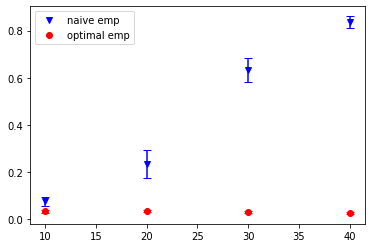

In [10]:
plt.plot(NL, m_naive_emp, 'v', label='naive emp', color='b')
plt.plot(NL, m_opt_emp, 'o', label='optimal emp', color='r')
plt.errorbar(NL, m_naive_emp, s_naive_emp, color='b', capsize=4, linestyle='')
plt.errorbar(NL, m_opt_emp, s_opt_emp, color='r', capsize=4, linestyle='')
plt.legend()

In [11]:
real_naive = pd.DataFrame({'nl': NL, 'm_naive_emp': m_naive_emp, 'm_opt_emp': m_opt_emp, 's_naive_emp': s_naive_emp, 's_opt_emp': s_opt_emp})  
real_naive.to_csv('DATA/real_naive.dat',sep=' ',index=False)

### II : Single-task vs Multi-task (2 tasks supervised)

In [12]:
tt = 0
nu = 100
NL = np.array([4,8,12,16,20,30,40])
nl2 = 50
n = len(NL)
nb_iter = 50
E_multi_emp = np.zeros((n,nb_iter))
E_single_emp = np.zeros((n,nb_iter))
E_multi_th = np.zeros((n,nb_iter))
E_single_th = np.zeros((n,nb_iter))
best = np.zeros(n)

In [13]:
for j in tqdm(range(nb_iter)):
    data_base = create_real_base(X, [['doberman','entlebucher'],['rottweiler','appenzeler']])
    data_base.center()
    data_base.normalize()
    for i in range(n):
        nl1 = NL[i]//2
        data = create_real(data_base, [[nl1,nl1],[nl2,nl2]], [[nu,nu],[0,0]])
        data.center()
        Mcal = data.Mcal('estimate')
        hp = HyperParameters(2)
        hp.compute_lambda(data,'estimate')
        hp.compute_alpha0(data)
        hp.alpha = 1e5*hp.alpha0
        a1, a2, B = small_dim(data, hp, Mcal, tt)
        E_multi_th[i,j] = error_opti(a1, a2, B)
        E_multi_emp[i,j] = np.mean(data.error_emp(hp, labels_opti(a1, a2, B), tt, threshold=0))
        
        data = create_real(data_base, [[nl1,nl1]], [[nu,nu]])
        data.center()
        Mcal = data.Mcal('estimate')
        hp = HyperParameters(1)
        hp.compute_lambda(data,'estimate')
        hp.compute_alpha0(data)
        hp.alpha = 1e5*hp.alpha0
        a1, a2, B = small_dim(data, hp, Mcal, tt)
        E_single_th[i,j] = error_opti(a1, a2, B)
        E_single_emp[i,j] = np.mean(data.error_emp(hp, labels_opti(a1, a2, B), tt, threshold=0))

  0%|          | 0/50 [00:00<?, ?it/s]/home/victor/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/victor/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
 28%|██▊       | 14/50 [03:41<08:54, 14.84s/it]/home/victor/Documents/Thèse/Code/tsp/hyperparameters.py:44: RuntimeWarning: invalid value encountered in sqrt
  self.lbd[t1,t2] = np.dot(m_0,m_1)/(np.sqrt(np.dot(m_0_0,m_0_1))*np.sqrt(np.dot(m_1_0,m_1_1)))
 50%|█████     | 25/50 [06:19<06:00, 14.42s/it]/home/victor/Documents/Thèse/Code/tsp/small_dim.py:12: RuntimeWarning: invalid value encountered in sqrt
  return stat.norm.sf(0.5*np.sqrt((a2-a1)@inv(B)@(a2-a1)))
100%|███

In [14]:
m_single_emp = np.mean(E_single_emp,axis=1)
s_single_emp = np.sqrt(np.var(E_single_emp,axis=1))/np.sqrt(nb_iter)

m_multi_emp = np.mean(E_multi_emp,axis=1)
s_multi_emp = np.sqrt(np.var(E_multi_emp,axis=1))/np.sqrt(nb_iter)

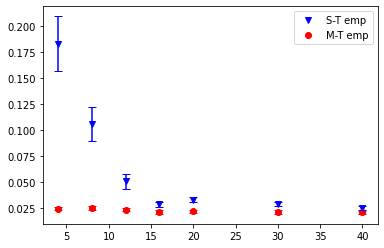

In [15]:
plt.plot(NL, m_single_emp, 'v', label='S-T emp', color='b')
plt.plot(NL, m_multi_emp, 'o', label='M-T emp', color='r')
plt.errorbar(NL, m_single_emp, s_single_emp, color='b', capsize=4, linestyle='')
plt.errorbar(NL, m_multi_emp, s_multi_emp, color='r', capsize=4, linestyle='')
plt.legend()

In [16]:
real_multi_task = pd.DataFrame({'nl': NL, 'm_single_emp': m_single_emp, 'm_multi_emp': m_multi_emp, 's_single_emp': s_single_emp, 's_multi_emp': s_multi_emp})  
real_multi_task.to_csv('DATA/real_multi_task.dat',sep=' ',index=False)

### III : Supervised vs Semi-supervised (1 task)

In [17]:
tt = 0
hp = HyperParameters(1)
nl = 5
NU = np.array([100,200,400,600,1000,1500,2000,2500,3000]) # NU = np.array([50,100,200,300,500,750,1000]) # 
n = len(NU)
nb_iter = 100
E_opt_emp = np.zeros((n,nb_iter))
E_sup_emp = np.zeros((n,nb_iter))
E_opt_th = np.zeros((n,nb_iter))
E_sup_th = np.zeros((n,nb_iter))

In [18]:
for j in tqdm(range(nb_iter)):
    data_base = create_real_base(X, [['boxer','swiss']])
    data_base.center()
    data_base.normalize()
    Mcal = data_base.Mcal('estimate')
    hp.compute_lambda(data_base,'estimate')
    for i in range(n):
        nu = NU[i]//2
        data = create_real(data_base, [[nl,nl]], [[nu,nu]])
        data.center()
        hp.compute_alpha0(data)
        hp.optim_alpha(data, Mcal, tt)
        a1, a2, B = small_dim(data, hp, Mcal, tt)
        E_opt_th[i,j] = error_opti(a1, a2, B)
        E_opt_emp[i,j] = np.mean(data.error_emp(hp, labels_opti(a1, a2, B), tt, threshold=0))
        
        hp.alpha = 1e5*hp.alpha0
        a1, a2, B = small_dim(data, hp, Mcal, tt)
        E_sup_th[i,j] = error_opti(a1, a2, B)
        E_sup_emp[i,j] = np.mean(data.error_emp(hp, labels_opti(a1, a2, B), tt, threshold=0))

100%|██████████| 100/100 [1:02:00<00:00, 33.05s/it]


In [19]:
m_sup_emp = np.mean(E_sup_emp,axis=1)
s_sup_emp = np.sqrt(np.var(E_sup_emp,axis=1))/np.sqrt(nb_iter)

m_opt_emp = np.mean(E_opt_emp,axis=1)
s_opt_emp = np.sqrt(np.var(E_opt_emp,axis=1))/np.sqrt(nb_iter)

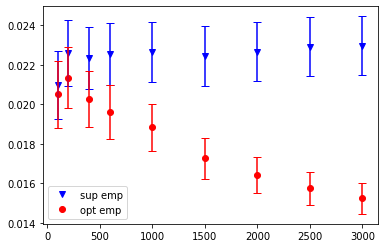

In [20]:
plt.plot(NU, m_sup_emp, 'v', label='sup emp', color='b')
plt.plot(NU, m_opt_emp, 'o', label='opt emp', color='r')
plt.errorbar(NU, m_sup_emp, s_sup_emp, color='b', capsize=4, linestyle='')
plt.errorbar(NU, m_opt_emp, s_opt_emp, color='r', capsize=4, linestyle='')
plt.legend()

In [21]:
real_semi_sup = pd.DataFrame({'nu': NU, 'm_sup_emp': m_sup_emp, 'm_opt_emp': m_opt_emp, 's_sup_emp': s_sup_emp, 's_opt_emp': s_opt_emp})  
real_semi_sup.to_csv('DATA/real_semi_sup.dat',sep=' ',index=False)